In [13]:
# main libraries
import pandas as pd
import numpy as np
from datetime import date
import geopy
from geopy import distance
from math import sin, cos, sqrt, atan2, radians, log
import imblearn
from numpy import mean, where
from collections import Counter
import qgrid

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

ModuleNotFoundError: No module named 'qgrid'

In [3]:
df_test=pd.read_csv(
    'C:/Users/Noela_tm/6000/eai6000_group5/Data/fraudTest.csv')
df_train=pd.read_csv(
    'C:/Users/Noela_tm/6000/eai6000_group5/Data/fraudTrain.csv')  

fraud_df= df_test.append(df_train)

In [5]:
fraud_df.shape
#Craig I noticed that I started out with 23 columns and you started out with 28
#Did you do something to you files before loading them?
#What does everyone else have

(1852394, 23)

In [6]:
# Checking for missing values
fraud_df.isnull().any().sum()

0

In [14]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]

In [16]:
#Saving the new data frame since it take a while to create the new ones before after do the above steps and before the columns are dropped. 
fraud_df.to_csv('grp5_fraud_mod.csv')

In [17]:
#Read Modified Fraud File here to skip the feature generation...which can take a while
fraud_df = pd.read_csv("grp5_fraud_mod.csv")

In [18]:
fraud_df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,trans_date_trans_time,cc_num,merchant,category,amt,first,last,...,merch_long,is_fraud,txn_datetime,age,distance,hour,day,month,year,log_amt
0,0,0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,...,-81.200714,0,2020-06-21 12:14:25,52,24.613746,12,21,6,2020,1.050822
1,1,1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,...,-109.960431,0,2020-06-21 12:14:33,30,104.834043,12,21,6,2020,3.395850
2,2,2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,...,-74.196111,0,2020-06-21 12:14:53,50,59.204796,12,21,6,2020,3.720378
3,3,3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,...,-80.883061,0,2020-06-21 12:15:15,33,27.615117,12,21,6,2020,4.095178
4,4,4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,...,-85.884734,0,2020-06-21 12:15:17,65,104.423175,12,21,6,2020,1.160021


In [19]:
# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'Unnamed: 0.1',
    'trans_num',
    'trans_date_trans_time',
    'cc_num',
    'merchant',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'job',
    'dob',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [20]:
qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

NameError: name 'qgrid' is not defined

In [21]:
#create a lis to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender',]
#this is for the linear regression set and does not include amount - if we end up wanting to predict something else
#we would just need replace the log_amt column with something else
num_col = ['age','distance','year','month','day','hour','city_pop']

#this is for the logistic regression model where we are predicitng is_fraud
#num_col = ['log_amt','age','distance','year','month','day','hour','city_pop'] 

fraud_df['Target'] = fraud_df['log_amt'] #can chane if we want something else #for linear regression model
#fraud_df['Target'] = fraud_df['is_fraud'] #for logistic regression model

In [22]:
#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [23]:
fraud_df[cat_col_onehotencode].head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [24]:
fraud_df = fraud_df.drop(['category','gender'],axis=1)

In [25]:
#Count all the columns and put them togeather into one variable for easy tracking
#does not include the log_amt column.
print('Total number of features: {}'.format(len(num_col + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
input_col = (num_col + cat_col_onehotencode)

Total number of features: 21
Numerical Features: 7
Categorical Features: 14


In [26]:
fraud_df.head()

,txn_datetime,Unnamed: 0.1.1,amt,city_pop,age,distance,hour,day,month,year,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2020-06-21 12:14:25,0,2.86,333497,52,24.613746,12,21,6,2020,...,0,0,0,0,0,1,0,0,0,1
1,2020-06-21 12:14:33,1,29.84,302,30,104.834043,12,21,6,2020,...,0,0,0,0,0,1,0,0,0,0
2,2020-06-21 12:14:53,2,41.28,34496,50,59.204796,12,21,6,2020,...,1,0,0,0,0,0,0,0,0,0
3,2020-06-21 12:15:15,3,60.05,54767,33,27.615117,12,21,6,2020,...,0,0,0,0,1,0,0,0,0,1
4,2020-06-21 12:15:17,4,3.19,1126,65,104.423175,12,21,6,2020,...,0,0,0,0,0,0,0,0,1,1


In [27]:
fraud_df.columns

Index(['txn_datetime', 'Unnamed: 0.1.1', 'amt', 'city_pop', 'age', 'distance',
       'hour', 'day', 'month', 'year', 'log_amt', 'is_fraud', 'Target',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M'],
      dtype='object')

In [31]:
features = ['amt', 'city_pop', 'age', 'distance', 'hour', 'day',
       'month', 'year', 'log_amt', 'Target','category_food_dining',
       'category_gas_transport','category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M']
target = ['is_fraud']
from sklearn import preprocessing
# Separating out the features
x = fraud_df.loc[:, features].values
# Separating out the target
y = fraud_df.loc[:,target].values
# Standardizing the features
x = preprocessing.StandardScaler().fit_transform(x)

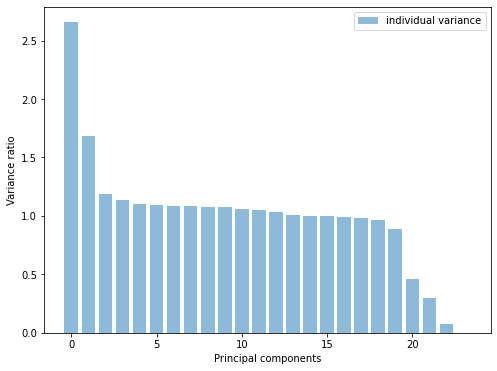

In [35]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(x)
pca_variance = pca.explained_variance_
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(24), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [36]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
principal_df

,principal component 1,principal component 2
0,-2.325837,-0.057495
1,-0.385182,0.764617
2,0.059134,0.744871
3,0.277710,-0.363544
4,-2.673137,-0.618497
...,...,...
1852389,-0.643293,-0.420088
1852390,0.272861,0.630212
1852391,0.992879,0.737926
1852392,0.631731,0.746651


In [37]:
fraud = pd.DataFrame(data=y, columns = ['is_fraud'])
final_df = pd.concat([principal_df, fraud[['is_fraud']]], axis = 1)
final_df

,principal component 1,principal component 2,is_fraud
0,-2.325837,-0.057495,0
1,-0.385182,0.764617,0
2,0.059134,0.744871,0
3,0.277710,-0.363544,0
4,-2.673137,-0.618497,0
...,...,...,...
1852389,-0.643293,-0.420088,0
1852390,0.272861,0.630212,0
1852391,0.992879,0.737926,0
1852392,0.631731,0.746651,0


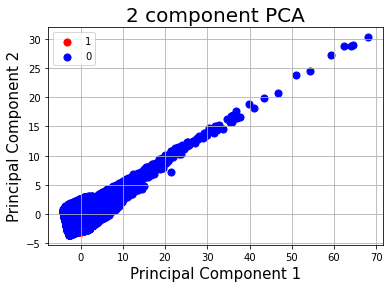

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['is_fraud'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
               , final_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


In [44]:
#build Training/Validation/Test Samples 
def Train_Valid_Test_Split(df,seed,tr):
    #First Shuffle the data
    df = df.sample(n = len(df), random_state=seed)
    df = df.reset_index(drop = True)

    #Splits Training Data = tr% - Validation & Test = (1-tr)/2
    #First take (1-tr) for Validation and Test
    valid_test=df.sample(frac=(1-tr),random_state=seed)

    #Then Split the validation and test data in half 
    valid = valid_test.sample(frac=0.50,random_state=seed)
    test = valid_test.drop(valid.index)

    #The remodeling data is use for training data
    train=df.drop(valid_test.index)
    
    return train, valid, test

#I used a 60% split for trian, 20% for vaild and 20% for Test because that is what the proff recommended. 
train,valid,test = Train_Valid_Test_Split(fraud_df[input_col +['Target']],12,.7)#(dataframe,randomseed,train split)

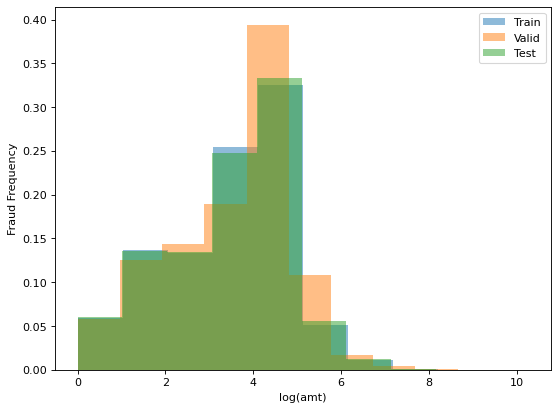

All samples (n = 1,852,394) accounted for.


In [45]:
#check to make sure all samples are accounted for and distribution of continous variable matches across data sets
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(train['Target'], alpha=0.5, label='Train',density=True)
plt.hist(valid['Target'], alpha=0.5, label='Valid',density=True)
plt.hist(test['Target'], alpha=0.5, label='Test',density=True)
plt.legend(loc='upper right')
plt.title = ('log(amt) Distribution in Split Datasets')
plt.xlabel('log(amt)')
plt.ylabel('Fraud Frequency')
plt.show()

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'

In [46]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

#check to make sure all samples are accounted for and prevelence of classification target variable matches across data sets
print('Target checks:')
print('Test prevalence(n = {:0,d}):{:.3f}'.format(len(test),calc_prevalence(test.Target.values)))
print('Valid prevalence(n = {:0,d}):{:.3f}'.format(len(valid),calc_prevalence(valid.Target.values)))
print('Train all prevalence(n = {:0,d}):{:.3f}'.format(len(train),calc_prevalence(train.Target.values)))

#check all records are accounted for
print('All samples (n = {:0,d}) accounted for.'.format(len(fraud_df)))
assert len(fraud_df) == (len(test)+len(valid)+len(train)),'math didnt work'
print('For continous variables the prevelence is actually the average of the target variable')

Target checks:
Test prevalence(n = 277,859):3.452
Valid prevalence(n = 277,859):3.457
Train all prevalence(n = 1,296,676):3.456
All samples (n = 1,852,394) accounted for.
For continous variables the prevelence is actually the average of the target variable


In [47]:
#change data sets into maxtrix objects for the models
X_train = train[input_col].values
X_valid = valid[input_col].values
X_test = test[input_col].values

y_train = train['Target'].values
y_valid = valid['Target'].values
y_test = test['Target'].values

In [48]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(1296676, 21)
(277859, 21)
(277859, 21)
(1296676,)
(277859,)
(277859,)


In [57]:
from sklearn.datasets import make_classification
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn import pipeline
# Oversample with SMOTE and random undersample for imbalanced dataset
# Define dataset
X_train, y_train = make_classification(n_samples=12000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

# Summarize class distribution
counter = Counter(y_train)
print(counter)

# Define pipeline
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train)
print(counter)


# Scatter plot of examples by class label
plt.figure(figsize=(12, 8))
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))

plt.legend()
plt.show()

Counter({0: 11880, 1: 120})


NameError: name 'Pipeline' is not defined

In [58]:
# Grid search k value for SMOTE oversampling for imbalanced classification
# Define dataset
x_train, y_train = make_classification(n_samples=12000, n_features=2, n_redundant=0, n_clusters_per_class=1, 
                           weights=[0.99], flip_y=0, random_state=1)

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
# Define pipeline
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.2, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    
# Evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % mean(scores))

NameError: name 'DecisionTreeClassifier' is not defined

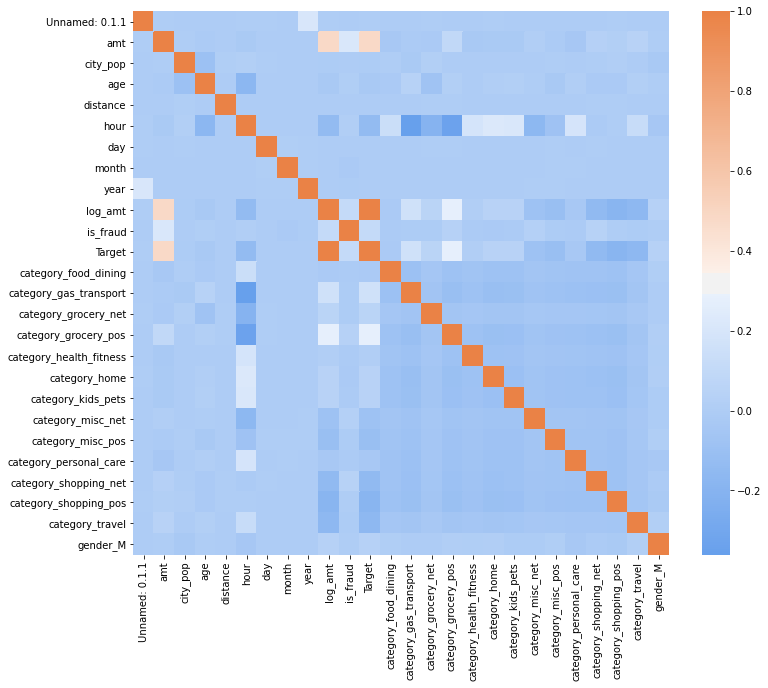

In [61]:
import seaborn as sns
from seaborn import heatmap
corrMatrix = fraud_df.corr()
#print (corrMatrix)
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(250, 30, s=80, l=65, as_cmap=True)
sns.heatmap(corrMatrix, cmap=cmap)
plt.show()

In [ ]:
#Generate a Linear and a LLogistic Regression Model to predict an outcome. 
#Explain the results of the model using performance metrics such as Coefficient of determination, QQ Plots Residual Plots, Confusion Matrix etc.
#Improve hte model using regularization and addres multicollnearity in the data
#Explain your modeling conclusions

In [63]:
fraud_df.head(10)

,txn_datetime,Unnamed: 0.1.1,amt,city_pop,age,distance,hour,day,month,year,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2020-06-21 12:14:25,0,2.86,333497,52,24.613746,12,21,6,2020,...,0,0,0,0,0,1,0,0,0,1
1,2020-06-21 12:14:33,1,29.84,302,30,104.834043,12,21,6,2020,...,0,0,0,0,0,1,0,0,0,0
2,2020-06-21 12:14:53,2,41.28,34496,50,59.204796,12,21,6,2020,...,1,0,0,0,0,0,0,0,0,0
3,2020-06-21 12:15:15,3,60.05,54767,33,27.615117,12,21,6,2020,...,0,0,0,0,1,0,0,0,0,1
4,2020-06-21 12:15:17,4,3.19,1126,65,104.423175,12,21,6,2020,...,0,0,0,0,0,0,0,0,1,1
5,2020-06-21 12:15:37,5,19.55,520,29,86.045959,12,21,6,2020,...,0,0,1,0,0,0,0,0,0,0
6,2020-06-21 12:15:44,6,133.93,1139,69,134.408462,12,21,6,2020,...,1,0,0,0,0,0,0,0,0,0
7,2020-06-21 12:15:50,7,10.37,343,48,82.907939,12,21,6,2020,...,0,0,0,0,0,1,0,0,0,0
8,2020-06-21 12:16:10,8,4.37,3688,47,61.401541,12,21,6,2020,...,0,0,0,0,0,0,0,1,0,1
9,2020-06-21 12:16:11,9,66.54,263,64,44.193728,12,21,6,2020,...,0,0,0,0,0,0,0,0,0,0


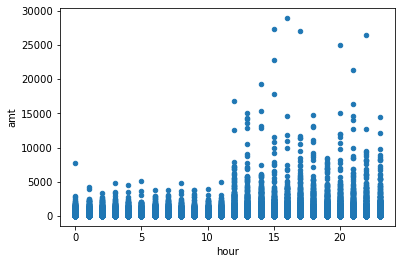

In [86]:
fraud_df.plot(kind='scatter',x='hour',y='amt')
plt.show()

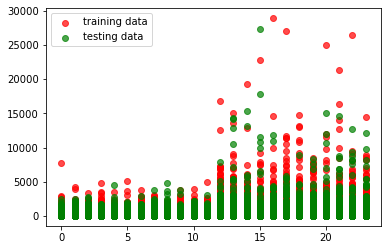

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(fraud_df.hour,fraud_df.amt)
plt.scatter(X_train,y_train,label='training data', color='r', alpha=.7)
plt.scatter(X_test, y_test, label='testing data', color='g', alpha=.7)
plt.legend()
plt.show()



In [81]:
LR=LinearRegression()
LR.fit(X_train.values.reshape(-1,1),y_train.values)

LinearRegression()

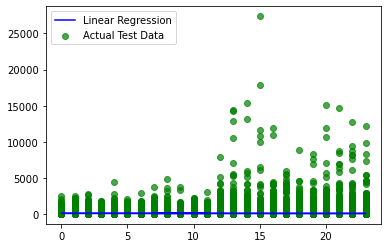

In [84]:
#Use model to predict on TEST Data
prediction=LR.predict(X_test.values.reshape(-1,1))
#Plot Prediction lineagainst actual test data
plt.plot(X_test,prediction,label='Linear Regression',color='b')
plt.scatter(X_test, y_test, label='Actual Test Data', color='g', alpha=.7)
plt.legend()
plt.show()

In [87]:
LR.predict(np.array([[12]]))[0]

70.44035349289558

In [89]:
LR.score(X_test.values.reshape(-1,1),y_test.values)
#The max it could be is 1.0, so this model is not very accurate

0.0005404069007810541

In [106]:
kids_df=fraud_df[(fraud_df.category_kids_pets ==1)]
kids_df=kids_df.drop(['category_travel','category_personal_care','category_shopping_pos','category_food_dining','category_grocery_net','category_gas_transport','category_misc_pos','category_health_fitness','category_grocery_pos','category_home','category_misc_net','category_shopping_net'], axis=1)

In [107]:
print(kids_df.head())

          txn_datetime  Unnamed: 0.1.1    amt  city_pop  age    distance  \
0  2020-06-21 12:14:25               0   2.86    333497   52   24.613746   
1  2020-06-21 12:14:33               1  29.84       302   30  104.834043   
2  2020-06-21 12:14:53               2  41.28     34496   50   59.204796   
3  2020-06-21 12:15:15               3  60.05     54767   33   27.615117   
4  2020-06-21 12:15:17               4   3.19      1126   65  104.423175   

   hour  day  month  year   log_amt  is_fraud    Target  category_kids_pets  \
0    12   21      6  2020  1.050822         0  1.050822                   1   
1    12   21      6  2020  3.395850         0  3.395850                   1   
2    12   21      6  2020  3.720378         0  3.720378                   1   
3    12   21      6  2020  4.095178         0  4.095178                   1   
4    12   21      6  2020  1.160021         0  1.160021                   1   

   gender_M  
0         1  
1         0  
2         0  
3         1 

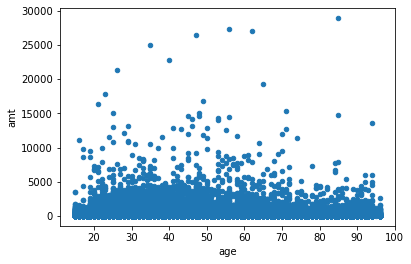

In [118]:
kids_df.plot(kind='scatter',x='age',y='amt')
plt.show()

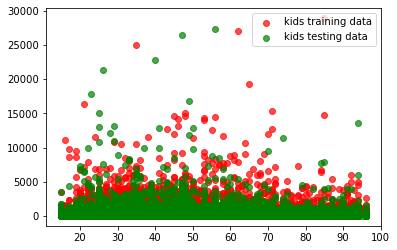

In [119]:
kids_X_train, kids_X_test, kids_y_train, kids_y_test = train_test_split(kids_df.age,kids_df.amt)
plt.scatter(kids_X_train,kids_y_train,label='kids training data', color='r', alpha=.7)
plt.scatter(kids_X_test, kids_y_test, label='kids testing data', color='g', alpha=.7)
plt.legend()
plt.show()

In [132]:
LR=LinearRegression()
LR.fit(kids_X_train.values.reshape(-1,1),kids_y_train.values)

LinearRegression()

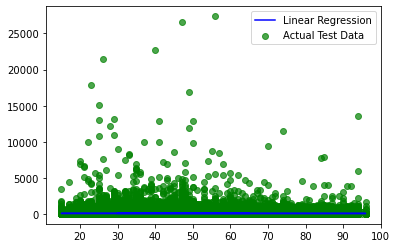

In [133]:
#Use model to predict on TEST Data
prediction=LR.predict(kids_X_test.values.reshape(-1,1))
#Plot Prediction lineagainst actual test data
plt.plot(kids_X_test,prediction,label='Linear Regression',color='b')
plt.scatter(kids_X_test, kids_y_test, label='Actual Test Data', color='g', alpha=.7)
plt.legend()
plt.show()

In [134]:
LR.predict(np.array([[30]]))[0]

71.24370577400211

In [136]:
LR.predict(np.array([[90]]))[0]

66.40346805132653

In [135]:
LR.score(kids_X_test.values.reshape(-1,1),kids_y_test.values)
#The max it could be is 1.0, so this model is not very accurate

0.0001536554037654403

In [141]:
xmas_df=fraud_df[(fraud_df.category_kids_pets ==1) & (fraud_df.month >9)]
xmas_df=xmas_df.drop(['category_travel','category_personal_care','category_shopping_pos','category_food_dining','category_grocery_net','category_gas_transport','category_misc_pos','category_health_fitness','category_grocery_pos','category_home','category_misc_net','category_shopping_net'], axis=1)
xmas_df.head()

,txn_datetime,Unnamed: 0.1.1,amt,city_pop,age,distance,hour,day,month,year,log_amt,is_fraud,Target,category_kids_pets,gender_M
274198,2020-10-01 00:00:02,274198,2.60,13717,70,102.627543,0,1,10,2020,0.955511,0,0.955511,1,0
274199,2020-10-01 00:00:06,274199,68.21,217,92,55.594243,0,1,10,2020,4.222591,0,4.222591,1,0
274200,2020-10-01 00:01:00,274200,72.59,2206,33,101.952224,0,1,10,2020,4.284827,0,4.284827,1,0
274201,2020-10-01 00:01:17,274201,78.69,34496,50,87.058687,0,1,10,2020,4.365516,0,4.365516,1,0
274202,2020-10-01 00:01:38,274202,443.30,344,53,118.665616,0,1,10,2020,6.094247,0,6.094247,1,0


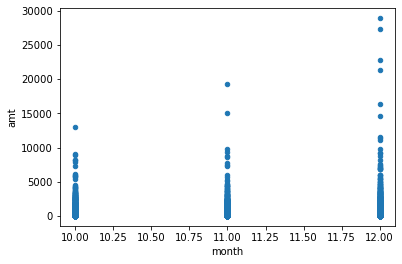

In [142]:
xmas_df.plot(kind='scatter',x='month',y='amt')
plt.show()

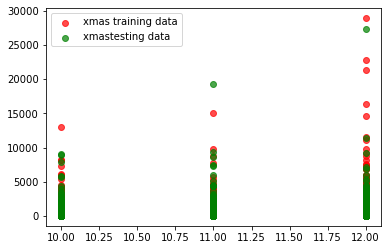

In [143]:
xmas_X_train, xmas_X_test, xmas_y_train, xmas_y_test = train_test_split(xmas_df.month,xmas_df.amt)
plt.scatter(xmas_X_train,xmas_y_train,label='xmas training data', color='r', alpha=.7)
plt.scatter(xmas_X_test, xmas_y_test, label='xmastesting data', color='g', alpha=.7)
plt.legend()
plt.show()

In [144]:
LR=LinearRegression()
LR.fit(xmas_X_train.values.reshape(-1,1),xmas_y_train.values)

LinearRegression()

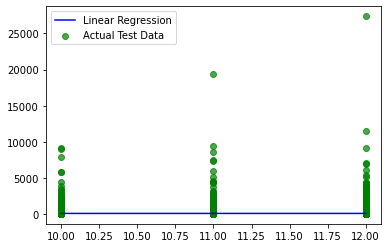

In [145]:
#Use model to predict on TEST Data
prediction=LR.predict(xmas_X_test.values.reshape(-1,1))
#Plot Prediction lineagainst actual test data
plt.plot(xmas_X_test,prediction,label='Linear Regression',color='b')
plt.scatter(xmas_X_test, xmas_y_test, label='Actual Test Data', color='g', alpha=.7)
plt.legend()
plt.show()

In [146]:
## Logistic Regression
fraud_df.head(10)

,txn_datetime,Unnamed: 0.1.1,amt,city_pop,age,distance,hour,day,month,year,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2020-06-21 12:14:25,0,2.86,333497,52,24.613746,12,21,6,2020,...,0,0,1,0,0,1,0,0,0,1
1,2020-06-21 12:14:33,1,29.84,302,30,104.834043,12,21,6,2020,...,0,0,1,0,0,1,0,0,0,0
2,2020-06-21 12:14:53,2,41.28,34496,50,59.204796,12,21,6,2020,...,1,0,1,0,0,0,0,0,0,0
3,2020-06-21 12:15:15,3,60.05,54767,33,27.615117,12,21,6,2020,...,0,0,1,0,1,0,0,0,0,1
4,2020-06-21 12:15:17,4,3.19,1126,65,104.423175,12,21,6,2020,...,0,0,1,0,0,0,0,0,1,1
5,2020-06-21 12:15:37,5,19.55,520,29,86.045959,12,21,6,2020,...,0,0,1,0,0,0,0,0,0,0
6,2020-06-21 12:15:44,6,133.93,1139,69,134.408462,12,21,6,2020,...,1,0,1,0,0,0,0,0,0,0
7,2020-06-21 12:15:50,7,10.37,343,48,82.907939,12,21,6,2020,...,0,0,1,0,0,1,0,0,0,0
8,2020-06-21 12:16:10,8,4.37,3688,47,61.401541,12,21,6,2020,...,0,0,1,0,0,0,0,1,0,1
9,2020-06-21 12:16:11,9,66.54,263,64,44.193728,12,21,6,2020,...,0,0,1,0,0,0,0,0,0,0


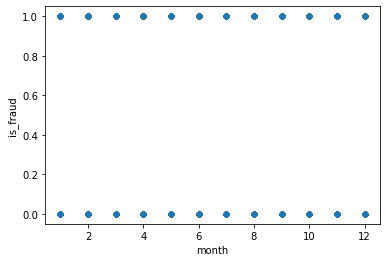

In [150]:
fraud_df.plot(kind='scatter',x='month',y='is_fraud')
plt.show()